In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import pandas as pd

A_file_path = "/content/drive/MyDrive/Uni/YEAR 3/MIE363/MIE363: Project 1/A - AmbulanceCalls.xlsx"
B_file_path = "/content/drive/MyDrive/Uni/YEAR 3/MIE363/MIE363: Project 1/B - BreweryProduction.xlsx"
C_file_path = "/content/drive/MyDrive/Uni/YEAR 3/MIE363/MIE363: Project 1/C - ClimateData.xlsx"
df_A = pd.read_excel(A_file_path)
df_B = pd.read_excel(B_file_path)
df_C = pd.read_excel(C_file_path)



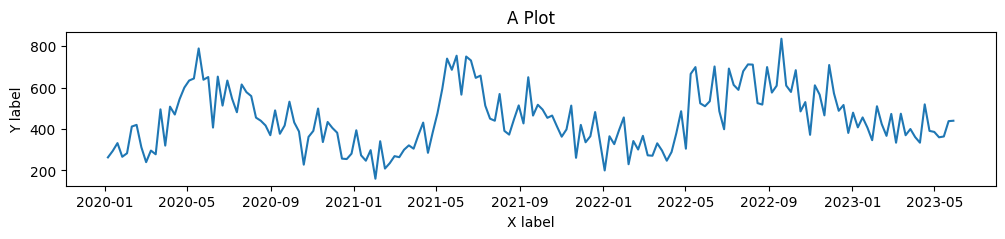

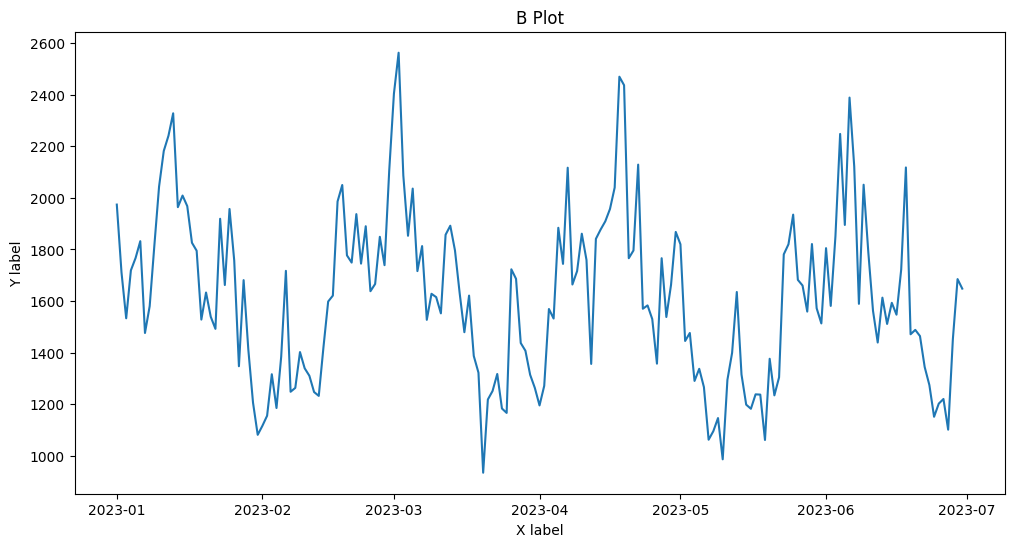

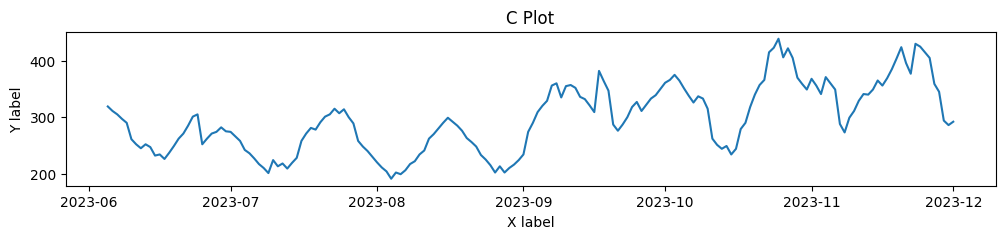

In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize = (12,2))
plt.plot(df_A['date'], df_A['calls'])
plt.xlabel('X label')
plt.ylabel('Y label')
plt.title('A Plot')
plt.show()

plt.figure(figsize = (12,6))
plt.plot(df_B['date'], df_B['kilolitres'])
plt.xlabel('X label')
plt.ylabel('Y label')
plt.title('B Plot')
plt.show()

plt.figure(figsize = (12,2))
plt.plot(df_C['Date'], df_C['ppm'])
plt.xlabel('X label')
plt.ylabel('Y label')
plt.title('C Plot')
plt.show()

In [4]:
seasonal_diff = df_B['kilolitres'].diff(20)


In [5]:
seasonal_diff

,kilolitres
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
176,-1169.0
177,-1021.0
178,-137.0
179,-366.0


In [6]:
seasonal_diff = seasonal_diff.dropna()


In [7]:
seasonal_diff

,kilolitres
20,-435.0
21,-219.0
22,386.0
23,-57.0
24,190.0
...,...
176,-1169.0
177,-1021.0
178,-137.0
179,-366.0


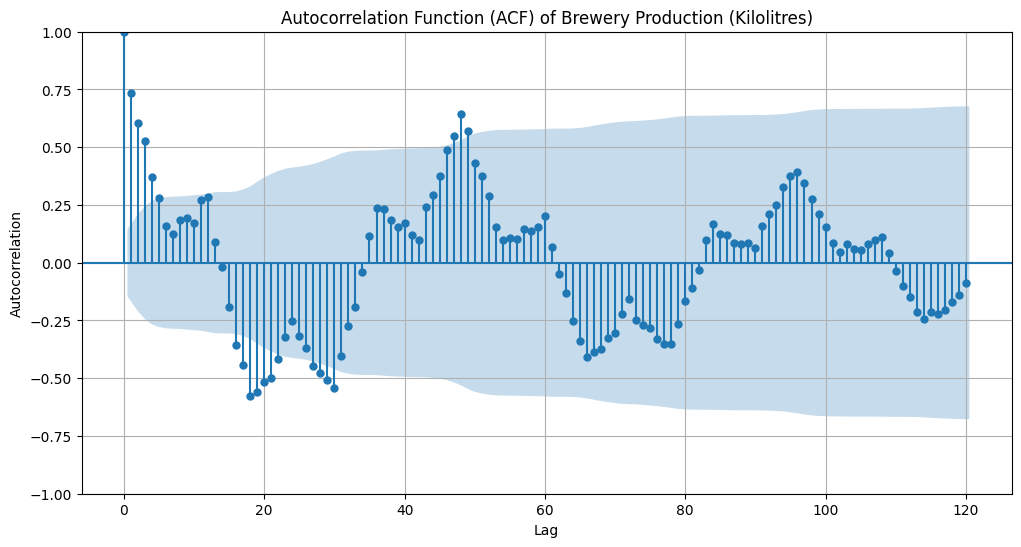

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Trends
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_B['kilolitres'], ax=ax, lags=120) # Plot ACF up to 50 lags, adjust as needed
ax.set_title('Autocorrelation Function (ACF) of Brewery Production (Kilolitres)')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.grid(True)
plt.show()

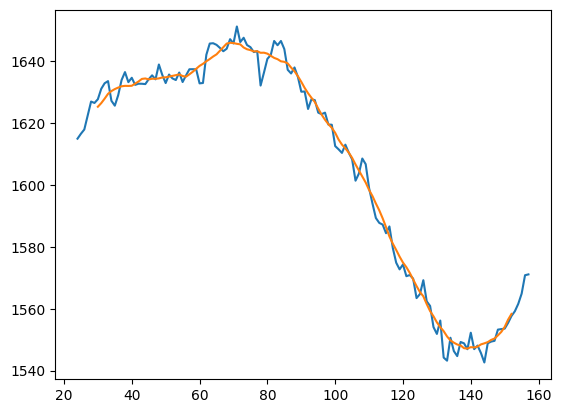

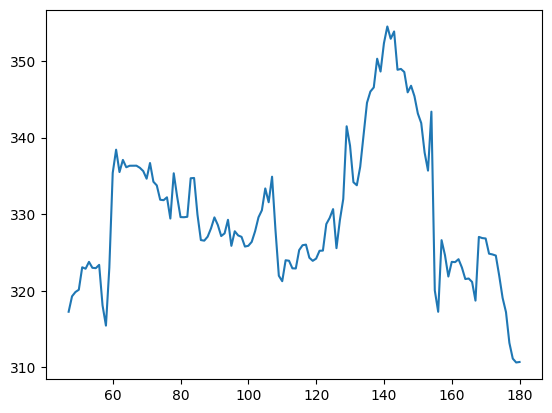

In [14]:
# doing moving window of 48 days
rolling_window = df_B['kilolitres'].rolling(window=48, center=True).mean()
plt.plot(rolling_window)
plt.plot((df_B['kilolitres'].rolling(window=12, center=True).mean()).rolling(window=48, center=True).mean())
plt.show()
plt.plot(df_B['kilolitres'].rolling(window=48).std())


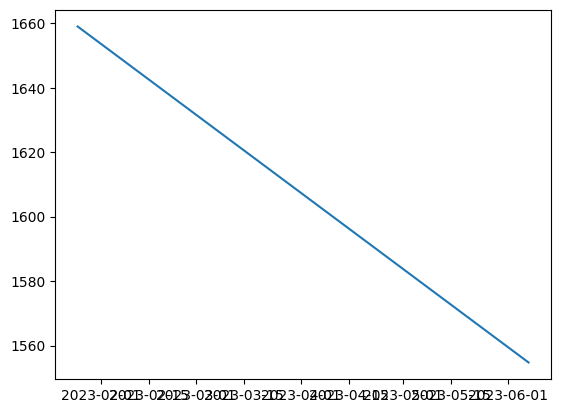

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Drop NaN values from rolling_window to get the data for trend fitting
best_line = df_B['kilolitres'].rolling(window=48, center=True).mean().dropna()

# Get the corresponding dates for the best_line
x_dates_for_fit = df_B['date'].loc[best_line.index]

# Convert these dates to a numerical format suitable for polyfit
x_numeric_for_fit = mdates.date2num(x_dates_for_fit)

# Perform linear regression to find the trend (m, b) from the rolling mean
m, b = np.polyfit(x_numeric_for_fit, best_line.values, 1)

# Convert all dates in df_B to numerical format to calculate the trend over the entire series
all_dates_numeric = mdates.date2num(df_B['date'])

# Calculate the trend line for all data points using the derived m and b
trend_line_full = m * all_dates_numeric + b

# Create best_fit_df for the full trend line, which will be used for detrending and plotting
best_fit_df = pd.DataFrame({'date': df_B['date'], 'trend_line': trend_line_full})

# Plotting the original data, rolling mean, and the calculated trend line
plt.figure(figsize=(14, 7))
plt.plot(df_B['date'], df_B['kilolitres'], label='Original Kilolitres', alpha=0.7)
plt.plot(x_dates_for_fit, best_line.values, label='48-period Rolling Mean', color='red')
plt.plot(best_fit_df['date'], best_fit_df['trend_line'], color='green', linestyle='--', label='Trend Line (from Rolling Mean)')
plt.title('Brewery Production (Kilolitres) with Rolling Mean and Trend')
plt.xlabel('Date')
plt.ylabel('Kilolitres')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
best_fit_df = pd.DataFrame({'date': x_axis, 'trend_line': m*x+b})

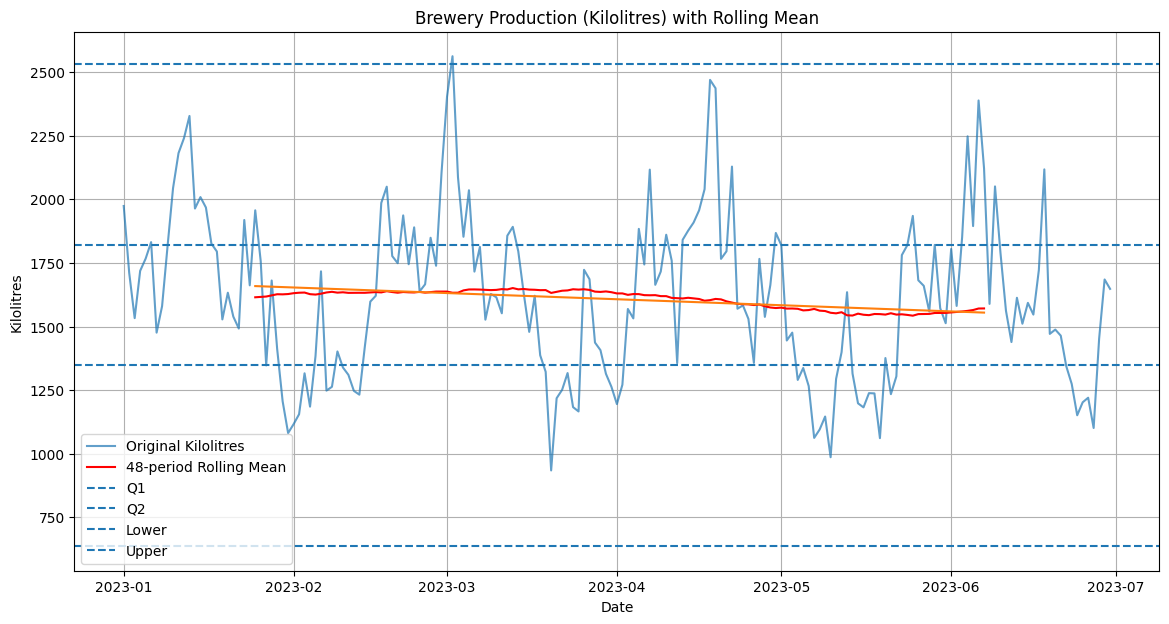

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_B['date'], df_B['kilolitres'], label='Original Kilolitres', alpha=0.7)
plt.plot(df_B['date'], df_B['kilolitres'].rolling(window=48,center=True).mean(), label='48-period Rolling Mean', color='red')
plt.plot(best_fit_df['date'], best_fit_df['trend_line'], color='green', linestyle='--', label='Trend Line') # Use best_fit_df created in PXCoz959vwtt
plt.title('Brewery Production (Kilolitres) with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Kilolitres')
plt.legend()
plt.grid(True)
plt.show()

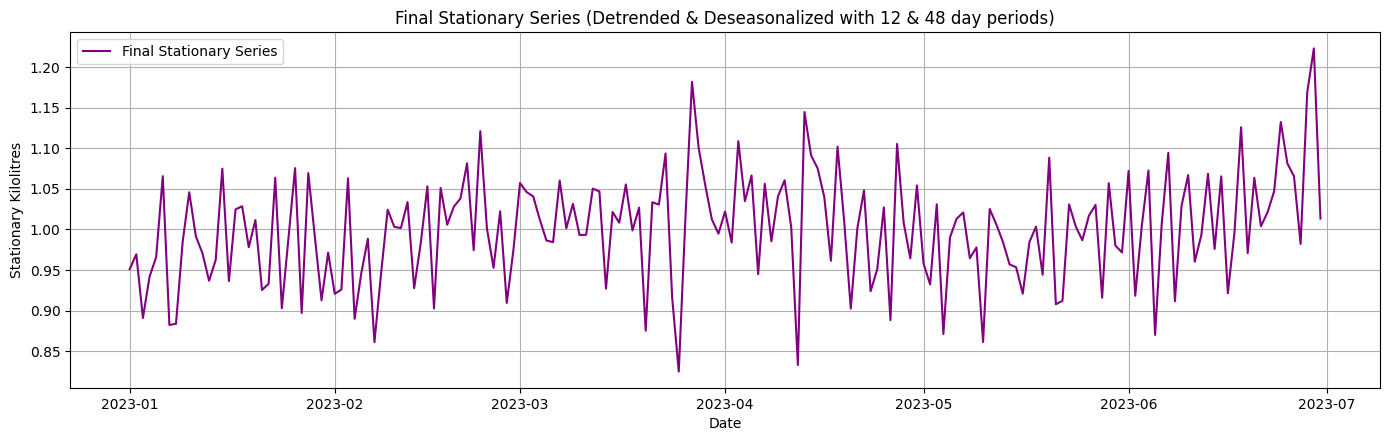

In [69]:


import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates # Ensure this is imported if not already

# Ensure df_B['date'] is datetime type for consistency
if not pd.api.types.is_datetime64_any_dtype(df_B['date']):
    df_B['date'] = pd.to_datetime(df_B['date'])

# Checking for outliers: Make data stationary

# remove trend
t = np.arange(1, len(df_B)+1)
detrend_data = df_B['kilolitres'] - ((m * t))

# remove small season
df_B['seasonal_idx_12'] = df_B.index % 12
seasonal_component_12 = detrend_data.groupby(df_B['seasonal_idx_12']).transform('mean')
deseason_small = detrend_data / seasonal_component_12

# remove large season
df_B['seasonal_idx_48'] = df_B.index % 48
seasonal_component_48 = deseason_small.groupby(df_B['seasonal_idx_48']).transform('mean')
deseason_large = deseason_small / seasonal_component_48

# Plotting the results to visualize the transformations
plt.figure(figsize=(14, 20)) # Increased figure height for more subplots

# plt.subplot(5, 1, 1)
# plt.plot(df_B['date'], df_B['kilolitres'], label='Original Kilolitres')
# plt.title('Original Brewery Production (Kilolitres)')
# plt.legend()
# plt.grid(True)

# plt.subplot(5, 1, 2)
# plt.plot(df_B['date'], detrend_data, label='Detrended Kilolitres')
# plt.title('Detrended Brewery Production (Kilolitres)')
# plt.legend()
# plt.grid(True)

# plt.subplot(5, 1, 3)
# plt.plot(df_B['date'], deseason_small, label='Deseasonalized (12-day period) Kilolitres')
# plt.title('Deseasonalized (12-day period) Brewery Production (Kilolitres)')
# plt.legend()
# plt.grid(True)

# plt.subplot(5, 1, 4)
# plt.plot(df_B['date'], deseason_large, label='Deseasonalized (48-day period) Kilolitres')
# plt.title('Deseasonalized (48-day period) Brewery Production (Kilolitres)')
# plt.xlabel('Date')
# plt.ylabel('Kilolitres')
# plt.legend()
# plt.grid(True)

# Also plot the final stationary series
plt.subplot(5, 1, 5)
plt.plot(df_B['date'], deseason_large, label='Final Stationary Series', color='purple')
plt.title('Final Stationary Series (Detrended & Deseasonalized with 12 & 48 day periods)')
plt.xlabel('Date')
plt.ylabel('Stationary Kilolitres')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Clean up temporary seasonal index columns from df_B
df_B = df_B.drop(columns=['seasonal_idx_12', 'seasonal_idx_48'], errors='ignore')

In [71]:
deseason_large

,kilolitres
0,0.951136
1,0.969458
2,0.890934
3,0.941784
4,0.965935
...,...
176,1.065437
177,0.982150
178,1.168786
179,1.222983


In [73]:
Q1 = deseason_large.quantile(0.25)
Q3 = deseason_large.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = best_line[(best_line < lower) | (best_line > upper)]

print("Number of outliers:", len(outliers))


Number of outliers: 134


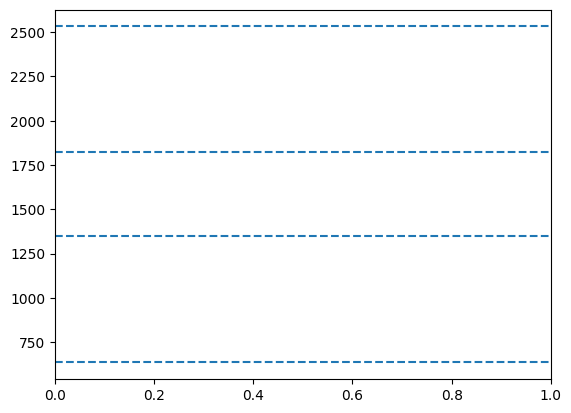